# Quantum Selected Configuration Interaction

In this tutorial we will introduce Quantum Selected Configuration Interaction (QSCI) from the quri-parts-qsci package in the context of early fault tolerant quantum computing (EFTQC)

## Overview

[QSCI](https://arxiv.org/abs/2302.11320) is a quantum algorithm that produces approximate ground states of some quantum Hamiltonian. This is done by sampling a trial wave-function that is believed to be an approximate solution to the problem and then reconstructing the Hamiltonian in the space spanned by the most significant computational basis states sampled.

- QSCI is sometimes considered an EFTQC algorithm because it benefits from using deep ansatze
- The accuracy of QSCI comes from the matrix diagonalization which is performed on classical hardware

In this notebook, we will use qsci to solve a small quantum chemistry problem. First we use coupled cluster (CC) theory to obtain an approximate solution, which we encode with the unitary coupled cluster singles and doubles (UCCSD) ansatz. Finally we will estimate the fidelity of the final state obtained by real devices. The flow and major take-aways from this notebook will be

1. Using `pyscf` to define an small molecule and obtain its qubit Hamiltonian as well as the CC ground state
2. Importing the `TrotterUCCSD` ansatz from `quri_parts.openfermion.ansatz` and populating its variational parameters using the CC solution
3. By using the `TrotterUCCSD` ansatz state, use `qsci` from `quri_parts_qsci` to obtain the QSCI ground state and ground state energy
4. Using QURI Parts' transpiler library to transpile the resulting circuits
5. Estimating the fidelity using QURI VM

To check out the source-code we use for qsci please have a look at our [open source repository](https://github.com/QunaSys/quri-parts-qsci/)

## Prerequisites

Although this notebook is pretty self-contained, users will benefit from first studying

- [Molecular Hamiltonian generation](https://quri-parts.qunasys.com/docs/tutorials/quantum-chemistry/hamiltonian/hamiltonian/)
- [Sampling estimation](https://quri-parts.qunasys.com/docs/tutorials/basics/sampling_estimation/)

## Setup and methodology testing

We start with a simple problem to test our setup and methodology. This is more like a sanity check than a real test, but we want to

* Define a $\textup{H}_2$ molecule
* Verify that CC solution works
* Verify that the trotterUCCSD solution (almost) replicates the CC energy
* Verify that QSCI improves on the CC energy

We first define the molecule below using `pyscf` and then using the `openfermion` submodule of `quri_parts` we convert it from a fermionic Hamiltonian to one that can operate on qubits. A lot of steps, such as applying the Jordan-Wigner transformation are performed for us automatically. If you are interested in learning about them in more detail, please see the QURI Parts documentation on the [fermion-to-qubit mapping](https://quri-parts.qunasys.com/docs/tutorials/basics/mapping/) and [molecular Hamiltonians](https://quri-parts.qunasys.com/docs/tutorials/quantum-chemistry/hamiltonian/hamiltonian/).

In [ ]:
import numpy as np

from pyscf import gto, scf, cc

from quri_parts.core.operator import get_sparse_matrix
from quri_parts.pyscf.mol import get_spin_mo_integrals_from_mole
from quri_parts.openfermion.mol import get_qubit_mapped_hamiltonian
from quri_parts.openfermion.ansatz import TrotterUCCSD


mole = gto.M(atom="H 0 0 0; H 0 0 1")
mf = scf.RHF(mole).run(verbose=0)
hamiltonian, mapping = get_qubit_mapped_hamiltonian(
    *get_spin_mo_integrals_from_mole(mole, mf.mo_coeff)
)


vals, vecs = np.linalg.eigh(get_sparse_matrix(hamiltonian).toarray())

casci_gs_e = np.min(vals)
ccsd = cc.CCSD(mf).run(verbose=0)

print("The exact ground state energy is:", casci_gs_e)
print("The coupled cluster singles and doubles energy is:", ccsd.e_tot)

The exact ground state energy is: -1.1011503302326187
The coupled cluster singles and doubles energy is: -1.1011503302444787


The coupled cluster energy is almost identical to the exact ground state energy. This is not surprising for a small problem like $\textup{H}_2$, but in general we expect there to be some error in the CCSD result.

### TrotterUCCSD

In QURI Parts the `TrotterUCCSD` ansatz is available. It is a quantum circuit version of the CCSD state which is generated by applying an excitation operator to a reference state (usually the Hartree-Fock state). The singles and doubles cluster operators
$$
\hat{T}_1 = \sum_i \sum_a t^i_a \hat{a}_a^\dagger\hat{a}_i
$$
$$
\hat{T}_2 = \frac{1}{4} \sum_i \sum_a t^{ij}_{ab} \hat{a}_a^\dagger\hat{a}_b^\dagger\hat{a}_j\hat{a}_i
$$
are used to generate the excitation operator
$$
e^T \approx e^{\hat{T}_1 + \hat{T}_2}
$$
in CCSD. The RHS is an approximation because $T$ may include higher order terms representing triple or higher excitations, which are not accounted for in CCSD. The ground state energy in coupled cluster theory is then
$$
\braket{\Psi_0|e^{-\hat{T}_1-\hat{T}_2}\hat{H}e^{\hat{T}_1 + \hat{T}_2}|\Psi_0} = E_\textup{CCSD}
$$

The excitation operator generates a set of states from a set of excited reference states, which must be orthogonal. This condition taken together with the above equation results in a set of non-linear algebraic equations, the coupled cluster equations, which are solved in order to obtain tensors $t^i_a$ and $t^{ij}_{ab}$ so as to minimize the ground state energy.

The Unitary coupled cluster (UCC) ansatz constructs unitary operators by taking a modified approach using anti-Hermitian cluster operators, constructed from the cluster operators from CC theory. Generically, the UCC energy is then obtained as
$$
\braket{\Psi_0|e^{-\hat{T}+\hat{T}^\dagger}\hat{H}e^{\hat{T} - \hat{T}^\dagger}|\Psi_0} = E_\textup{UCC},
$$
and $\hat{T}$ may again be truncated to include only singles and doubles if needed. The excitation operator can be generated through a Trotter decomposition, [which can be realized as a quantum circuit ansatz](https://pubs.acs.org/doi/10.1021/acs.jpca.3c02781). That is the `TrotterUCCSD` ansatz, which we will use in the following.

First we need a function that can convert the one-body and two-body cluster operators into parameters for the `TrotterUCCSD` ansatz.

In [ ]:
from typing import Sequence

import numpy.typing as npt


def ccsd_param_to_circuit_param(
    uccsd: TrotterUCCSD,
    n_electrons: int,
    t1: npt.NDArray[np.complex128],
    t2: npt.NDArray[np.complex128],
) -> Sequence[float]:
    in_param_list = uccsd.param_mapping.in_params
    param_list = []

    for param in in_param_list:
        name_split = param.name.split("_")
        if name_split[0] == "s":
            _, i_str, j_str = name_split
            i, j = int(i_str), int(j_str) - n_electrons // 2
            param_list.append(t1[i, j])

        if name_split[0] == "d":
            _, i_str, j_str, a_str, b_str = name_split
            i, j, b, a = (
                int(i_str),
                int(j_str),
                int(b_str) - n_electrons // 2,
                int(a_str) - n_electrons // 2,
            )
            param_list.append(t2[i, j, a, b])
    return param_list

We specify the numer of trotter steps and other metaparameters in the trotter UCCSD ansatz below

In [ ]:
TROTTER_STEPS = 1
USE_SINGLES = True
REDUCE_PARAMETER = True

Then the following code will generate the ansatz prepared with parameters obtained using coupled cluster theory

In [ ]:
mole.nelectron

2

In [ ]:
uccsd = TrotterUCCSD(
    mole.nao * 2,
    mole.nelectron,
    trotter_number=TROTTER_STEPS,
    use_singles=USE_SINGLES,
    singlet_excitation=REDUCE_PARAMETER,
)
param = ccsd_param_to_circuit_param(uccsd, mole.nelectron, ccsd.t1, ccsd.t2)

Let's check the energy obtained by the Trotterized UCCSD

In [ ]:
from quri_parts.qulacs.estimator import (
    create_qulacs_vector_concurrent_parametric_estimator,
)
from quri_parts.core.state import quantum_state, apply_circuit

hf_state = quantum_state(mole.nao * 2, bits=2**mole.nelectron - 1)
estimator = create_qulacs_vector_concurrent_parametric_estimator()
state = apply_circuit(uccsd, hf_state)
estimate = estimator(hamiltonian, state, [param])
print("The coupled cluster singles and doubles energy is:", ccsd.e_tot)
print(
    "The Trotter unitary coupled cluster singles and doubles energy is:",
    estimate[0].value.real,
)

The coupled cluster singles and doubles energy is: -1.1011503302444787
The Trotter unitary coupled cluster singles and doubles energy is: -1.1011464405909301


Here we see that the Trotter UCCSD energy is very close to the CCSD energy.

### Noise

We will incorporate a simple noise-model where only 2-qubit gates are assigned a physical error rate. The probability of error accumulates with the number of 2-qubit gates and we identify it with the probability of measuring a random quantum state when the circuit is executed. This is an implementation of depolarizing noise. Although this sounds like a complicated task, in QURI Parts, there is a straightforward way to do this. All we have to do is define our own sampler. We will do this by defining the `ConcurrentNoisySampler` and `ConcurrentNoisySamplingEstimator` below.

In QURI Parts, a call to a sampler looks like

`samples = sampler(circuits_shots_tuples)`

Here `samples` is a dictionary of readout values mapped to the number of times the given qubit register was measured. `circuits_shots_tuples` is an iterable of tuples, each tuple containing a quantum circuit and a number of sampling shots to assign to that quantum circuit. If `sampler` is an ideal sampler, i.e. it is unaffected by noise, but generates samples from a probability distribution obtained from the density of the wave-function, then we can create a noisy sampler from it by writing a wrapper for it. As mentioned in the last paragraph we identify the probability of error with the probability of measuring a random state. Therefore, in addition to the ideal sampler, we need a noise sampler that samples a random state regardless of the input it receives. Whether or not a circuit is sampled with the noise sampler or the ideal sampler is determined randomly based on the error probability.

In the code below we show how to write such a sampler and an estimator based on it.

In [ ]:
from collections import Counter
from typing import Iterable, Optional

import numpy as np
from numpy.random import default_rng
from quri_parts.circuit import NonParametricQuantumCircuit
from quri_parts.circuit.gate_names import TWO_QUBIT_GATE_NAMES
from quri_parts.core.sampling import ConcurrentSampler, MeasurementCounts
from quri_parts.core.estimator import (
    Estimate,
)
from quri_parts.core.estimator.sampling import (
    create_sampling_estimator,
)
from quri_parts.core.measurement import bitwise_commuting_pauli_measurement
from quri_parts.core.operator import Operator
from quri_parts.core.sampling import (
    PauliSamplingShotsAllocator,
)
from quri_parts.core.state import CircuitQuantumState
from quri_parts.qulacs.sampler import create_qulacs_vector_concurrent_sampler


def get_total_error_rate(
    gate_error_rate_2q: float,
    circuit_shots_tuples: Iterable[tuple[NonParametricQuantumCircuit, int]],
) -> float:
    r"""Returns the total error rate :math:`R` calculated from the user
    specified error rate :math:`r`. This noise model assumes that 1-qubit gate
    error is negligible and so only takes into account 2-qubit gates.

    The total error is given by
    :math: `R = 1 - (1 - r)^n_{2q}` where :math:`n_{2q}` is the number of 2-qubit gates.
    """
    gates = circuit_shots_tuples.__iter__().__next__()[0].gates
    n_2q_gates = sum(g.name in TWO_QUBIT_GATE_NAMES for g in gates)
    fidelity = 1 - gate_error_rate_2q
    total_error_rate = 1 - fidelity**n_2q_gates

    return total_error_rate


def split_circuits_shots_tuples(
    total_error_rate: float,
    circuit_shots_tuples: Iterable[tuple[NonParametricQuantumCircuit, int]],
) -> tuple[
    Iterable[tuple[NonParametricQuantumCircuit, int]],
    Iterable[tuple[NonParametricQuantumCircuit, int]],
]:
    noise_circuit_shots_tuples: list[tuple[NonParametricQuantumCircuit, int]] = []
    noise_free_circuit_shots_tuples: list[tuple[NonParametricQuantumCircuit, int]] = []
    for c, s in circuit_shots_tuples:
        noise_shot_counts = int(np.round(s * total_error_rate))
        noise_circuit_shots_tuples.append((c, noise_shot_counts))
        noise_free_circuit_shots_tuples.append((c, s - noise_shot_counts))

    return noise_free_circuit_shots_tuples, noise_circuit_shots_tuples


class NoiseSampler:
    def __init__(self, seed: Optional[int] = None) -> None:
        self._seed = seed
        self._rng = default_rng(seed)

    def _get_uniform_samples(self, n_qubits: int, n_shots: int) -> MeasurementCounts:
        dim = 2**n_qubits
        samples = self._rng.multinomial(
            n_shots,
            [
                1 / dim,
            ]
            * dim,  # Each computational basis state is equally likely
        )
        measurement_counts = {}
        for i, s in enumerate(samples):
            measurement_counts[i] = s

        return measurement_counts

    def __call__(
        self, circuit_shots_tuples: Iterable[tuple[NonParametricQuantumCircuit, int]]
    ) -> Iterable[MeasurementCounts]:
        measurement_counts = []
        n_qubits = circuit_shots_tuples.__iter__().__next__()[0].qubit_count
        for _, s in circuit_shots_tuples:
            measurement_counts.append(self._get_uniform_samples(n_qubits, s))

        return measurement_counts


class ConcurrentNoisySampler:
    def __init__(
        self,
        sampler: ConcurrentSampler,
        error_rate_2q: float = 0,
        seed: Optional[int] = None,
    ) -> None:
        self._sampler = sampler
        self._noise_sampler = NoiseSampler(seed)
        self._error_rate_2q = error_rate_2q
        self._seed = seed

    def _sample_with_noise(
        self, circuit_shots_tuples: Iterable[tuple[NonParametricQuantumCircuit, int]]
    ) -> Iterable[MeasurementCounts]:
        # Implement depolarizing noise channel by calculating effective error rate.
        # Interpret the error rate as the probaility that a sample will be random.
        # Split into noise and noise-free samples, which are sampled separately.
        # These samples are combined to obtain noisy samples.
        total_error_rate = get_total_error_rate(
            self._error_rate_2q, circuit_shots_tuples
        )
        (
            noise_free_circuit_shots_tuples,
            noise_circuit_shots_tuples,
        ) = split_circuits_shots_tuples(total_error_rate, circuit_shots_tuples)
        noise_free_measurement_counts = self._sampler(noise_free_circuit_shots_tuples)
        noise_measurement_counts = self._noise_sampler(noise_circuit_shots_tuples)
        measurement_counts = [
            Counter(t) + Counter(u)
            for t, u in zip(noise_measurement_counts, noise_free_measurement_counts)
        ]

        return measurement_counts

    def _sample_without_noise(
        self, circuit_shots_tuples: Iterable[tuple[NonParametricQuantumCircuit, int]]
    ) -> Iterable[MeasurementCounts]:
        measurement_counts = self._sampler(circuit_shots_tuples)

        return measurement_counts

    def __call__(
        self, circuit_shots_tuples: Iterable[tuple[NonParametricQuantumCircuit, int]]
    ) -> Iterable[MeasurementCounts]:
        if self._error_rate_2q:
            measurement_counts = self._sample_with_noise(circuit_shots_tuples)
        else:
            measurement_counts = self._sample_without_noise(circuit_shots_tuples)

        return measurement_counts


class ConcurrentNoisySamplingEstimator:
    def __init__(
        self,
        n_shots: int,
        allocator: PauliSamplingShotsAllocator,
        error_rate: float = 0,
        seed: Optional[int] = None,
    ) -> None:
        self._n_shots = n_shots
        measurement_factory = bitwise_commuting_pauli_measurement
        sampler = create_qulacs_vector_concurrent_sampler()
        self._sampler = ConcurrentNoisySampler(sampler, error_rate, seed)
        self._estimator = create_sampling_estimator(
            total_shots=n_shots,
            sampler=self._sampler,
            measurement_factory=measurement_factory,
            shots_allocator=allocator,
        )

    def __call__(
        self,
        operator: Operator,
        raw_param_state: CircuitQuantumState,
    ) -> Iterable[Estimate[complex]]:
        estimates = self._estimator(operator, raw_param_state)

        return estimates

Let's try to get an estimate of the UCCSD energy using the above circuit with a modest physical error rate

In [ ]:
from quri_parts.core.sampling.shots_allocator import create_proportional_shots_allocator

ERROR_RATE = 2.0 * 10**-5
TOTAL_SHOTS = 50000
hf_state = quantum_state(mole.nao * 2, bits=2**mole.nelectron - 1)
shots_allocator = create_proportional_shots_allocator()
estimator = ConcurrentNoisySamplingEstimator(
    n_shots=TOTAL_SHOTS, allocator=shots_allocator, error_rate=ERROR_RATE
)
state = apply_circuit(uccsd, hf_state)
bound_state = state.bind_parameters(param)
estimate = estimator(hamiltonian, bound_state)
print("The coupled cluster singles and doubles energy is:", ccsd.e_tot)
print(
    "The noisy Trotter unitary coupled cluster singles and doubles energy is:",
    estimate.value.real,
)

The coupled cluster singles and doubles energy is: -1.1011503302444787
The noisy Trotter unitary coupled cluster singles and doubles energy is: -1.1013475570262052


The error is clearly high compared to previously, but it's not too bad

### QSCI

We then run [qsci](https://arxiv.org/abs/2302.11320). To run it we have to specify the number of shots, the Hamiltonian, approximate ground states to draw samples from and the number of states to pick out. QSCI is especially sensitive to the number of states picked out as this both determines the accuracy of the end result as well as the complexity of the classical diagonalization. $\textup{H}_2$ has 2 electrons and in the STO-3g atomic orbital basis therefore 4 molecular orbitals, which each are represented by a qubit.

Since the logical value of each bit represents its occupancy, the number of states of interest is limited to those with a total occupation of $2$. For this reason, even though there are 16 basis states available in the quantum register, only 6 of them are relevant. Let us see how far we can get with only 4 of those 6 states.

In [ ]:
BASIS_STATES = 4
TOTAL_SHOTS = 50000

We will use an ideal sampler for now

In [ ]:
from quri_parts_qsci import qsci
from quri_parts.qulacs.sampler import create_qulacs_vector_concurrent_sampler

sampler = create_qulacs_vector_concurrent_sampler()
bound_state = state.bind_parameters(param)
eigs, _ = qsci(
    hamiltonian, [bound_state], sampler, total_shots=TOTAL_SHOTS, num_states_pick_out=4
)

So to summarize

In [ ]:
err = lambda x: abs(x / casci_gs_e - 1)
print(f"The exact GS energy is {casci_gs_e}")
print(
    f"The coupled cluster energy is {ccsd.e_tot}, with relative error {err(ccsd.e_tot)}"
)
print(
    f"The Trotter UCCSD energy is {estimate.value.real}, with relative error {err(estimate.value.real)}"
)
print(f"The qsci gs energy is {eigs[0]}, with relative error {err(eigs[0])}")

The exact GS energy is -1.1011503302326187
The coupled cluster energy is -1.1011503302444787, with relative error 1.0770717651098494e-11
The Trotter UCCSD energy is -1.1013475570262052, with relative error 0.0001791097801739916
The qsci gs energy is -1.1011503302326187, with relative error 0.0


In conclusion, for this simple system coupled cluster is enough to determine the GS energy with virtually no error. The Trotterized quantum gate version of the ansatz, i.e. Trotter UCCSD is still very accurate for this test case, but we can see that there is a finite error. Once we include noise, the error starts to become more noticable, however, it still produces a good enough quantum state to be used by QSCI later. QSCI then finds a ground state with virtually no error, even though the number of reference states sampled is 2/3 the total Hilbert space.

## $\textup{H}_N$

Let's try it again with a more interesting example, and let's add more qubits.

First we define functions that we will need. For convenience, we again duplicate the function that gives us circuit parameters from CCSD.

In [ ]:
import numpy.typing as npt
import numpy as np

from typing import Sequence
from quri_parts.openfermion.ansatz import TrotterUCCSD


def ccsd_param_to_circuit_param(
    uccsd: TrotterUCCSD,
    n_electrons: int,
    t1: npt.NDArray[np.complex128],
    t2: npt.NDArray[np.complex128],
) -> Sequence[float]:
    in_param_list = uccsd.param_mapping.in_params
    param_list = []

    for param in in_param_list:
        name_split = param.name.split("_")
        if name_split[0] == "s":
            _, i_str, j_str = name_split
            i, j = int(i_str), int(j_str) - n_electrons // 2
            param_list.append(t1[i, j])

        if name_split[0] == "d":
            _, i_str, j_str, a_str, b_str = name_split
            i, j, b, a = (
                int(i_str),
                int(j_str),
                int(b_str) - n_electrons // 2,
                int(a_str) - n_electrons // 2,
            )
            param_list.append(t2[i, j, a, b])
    return param_list

We also duplicate the noisy sampler and estimator

In [ ]:
from collections import Counter
from typing import Iterable, Optional

import numpy as np
from numpy.random import default_rng
from quri_parts.circuit import NonParametricQuantumCircuit
from quri_parts.circuit.gate_names import TWO_QUBIT_GATE_NAMES
from quri_parts.core.sampling import ConcurrentSampler, MeasurementCounts
from quri_parts.core.estimator import (
    Estimate,
)
from quri_parts.core.estimator.sampling import (
    create_sampling_estimator,
)
from quri_parts.core.measurement import bitwise_commuting_pauli_measurement
from quri_parts.core.operator import Operator
from quri_parts.core.sampling import (
    PauliSamplingShotsAllocator,
)
from quri_parts.core.state import CircuitQuantumState
from quri_parts.qulacs.sampler import create_qulacs_vector_concurrent_sampler


def get_total_error_rate(
    gate_error_rate_2q: float,
    circuit_shots_tuples: Iterable[tuple[NonParametricQuantumCircuit, int]],
) -> float:
    r"""Returns the total error rate :math:`R` calculated from the user
    specified error rate :math:`r`. This noise model assumes that 1-qubit gate
    error is negligible and so only takes into account 2-qubit gates.

    The total error is given by
    :math: `R = 1 - (1 - r)^n_{2q}` where :math:`n_{2q}` is the number of 2-qubit gates.
    """
    gates = circuit_shots_tuples.__iter__().__next__()[0].gates
    n_2q_gates = sum(g.name in TWO_QUBIT_GATE_NAMES for g in gates)
    fidelity = 1 - gate_error_rate_2q
    total_error_rate = 1 - fidelity**n_2q_gates

    return total_error_rate


def split_circuits_shots_tuples(
    total_error_rate: float,
    circuit_shots_tuples: Iterable[tuple[NonParametricQuantumCircuit, int]],
) -> tuple[
    Iterable[tuple[NonParametricQuantumCircuit, int]],
    Iterable[tuple[NonParametricQuantumCircuit, int]],
]:
    noise_circuit_shots_tuples: list[tuple[NonParametricQuantumCircuit, int]] = []
    noise_free_circuit_shots_tuples: list[tuple[NonParametricQuantumCircuit, int]] = []
    for c, s in circuit_shots_tuples:
        noise_shot_counts = int(np.round(s * total_error_rate))
        noise_circuit_shots_tuples.append((c, noise_shot_counts))
        noise_free_circuit_shots_tuples.append((c, s - noise_shot_counts))

    return noise_free_circuit_shots_tuples, noise_circuit_shots_tuples


class NoiseSampler:
    def __init__(self, seed: Optional[int] = None) -> None:
        self._seed = seed
        self._rng = default_rng(seed)

    def _get_uniform_samples(self, n_qubits: int, n_shots: int) -> MeasurementCounts:
        dim = 2**n_qubits
        samples = self._rng.multinomial(
            n_shots,
            [
                1 / dim,
            ]
            * dim,
        )
        measurement_counts = {}
        for i, s in enumerate(samples):
            measurement_counts[i] = s

        return measurement_counts

    def __call__(
        self, circuit_shots_tuples: Iterable[tuple[NonParametricQuantumCircuit, int]]
    ) -> Iterable[MeasurementCounts]:
        measurement_counts = []
        n_qubits = circuit_shots_tuples.__iter__().__next__()[0].qubit_count
        for _, s in circuit_shots_tuples:
            measurement_counts.append(self._get_uniform_samples(n_qubits, s))

        return measurement_counts


class ConcurrentNoisySampler:
    def __init__(
        self,
        sampler: ConcurrentSampler,
        error_rate_2q: float = 0,
        seed: Optional[int] = None,
    ) -> None:
        self._sampler = sampler
        self._noise_sampler = NoiseSampler(seed)
        self._error_rate_2q = error_rate_2q
        self._seed = seed

    def _sample_with_noise(
        self, circuit_shots_tuples: Iterable[tuple[NonParametricQuantumCircuit, int]]
    ) -> Iterable[MeasurementCounts]:
        # Implement depolarizing noise channel by calculating effective error rate.
        # Interpret the error rate as the probaility that a sample will be random.
        # Split into noise and noise-free samples, which are sampled separately.
        # These samples are combined to obtain noisy samples.
        total_error_rate = get_total_error_rate(
            self._error_rate_2q, circuit_shots_tuples
        )
        (
            noise_free_circuit_shots_tuples,
            noise_circuit_shots_tuples,
        ) = split_circuits_shots_tuples(total_error_rate, circuit_shots_tuples)
        noise_free_measurement_counts = self._sampler(noise_free_circuit_shots_tuples)
        noise_measurement_counts = self._noise_sampler(noise_circuit_shots_tuples)
        measurement_counts = [
            Counter(t) + Counter(u)
            for t, u in zip(noise_measurement_counts, noise_free_measurement_counts)
        ]

        return measurement_counts

    def _sample_without_noise(
        self, circuit_shots_tuples: Iterable[tuple[NonParametricQuantumCircuit, int]]
    ) -> Iterable[MeasurementCounts]:
        measurement_counts = self._sampler(circuit_shots_tuples)

        return measurement_counts

    def __call__(
        self, circuit_shots_tuples: Iterable[tuple[NonParametricQuantumCircuit, int]]
    ) -> Iterable[MeasurementCounts]:
        if self._error_rate_2q:
            measurement_counts = self._sample_with_noise(circuit_shots_tuples)
        else:
            measurement_counts = self._sample_without_noise(circuit_shots_tuples)

        return measurement_counts


class ConcurrentNoisySamplingEstimator:
    def __init__(
        self,
        n_shots: int,
        allocator: PauliSamplingShotsAllocator,
        error_rate: float = 0,
        seed: Optional[int] = None,
    ) -> None:
        self._n_shots = n_shots  # This is not the same as shot_count!
        measurement_factory = bitwise_commuting_pauli_measurement
        sampler = create_qulacs_vector_concurrent_sampler()
        self._sampler = ConcurrentNoisySampler(sampler, error_rate, seed)
        self._estimator = create_sampling_estimator(
            total_shots=n_shots,
            sampler=self._sampler,
            measurement_factory=measurement_factory,
            shots_allocator=allocator,
        )

    def __call__(
        self,
        operator: Operator,
        raw_param_state: CircuitQuantumState,
    ) -> Iterable[Estimate[complex]]:
        estimates = self._estimator(operator, raw_param_state)

        return estimates

We define metaparameters both for the `TrotterUCCSD` ansatz, but also `qsci` function.

In [ ]:
TROTTER_STEPS = 1
USE_SINGLES = True
REDUCE_PARAMETER = True
TOTAL_SHOTS = 50000
BASIS_STATES = 64
ERROR_RATE = 2.0 * 10**-5

The following function let's us obtain the Hamiltonian as well as derived objects such as the CCSD object, etc.

In [ ]:
from pyscf import gto, scf, cc
from scipy.sparse.linalg import eigsh

from quri_parts.core.operator import get_sparse_matrix
from quri_parts.pyscf.mol import get_spin_mo_integrals_from_mole
from quri_parts.openfermion.mol import get_qubit_mapped_hamiltonian
from quri_parts.chem.mol import ActiveSpace
from quri_parts.core.state import quantum_state, apply_circuit


def get_hn_hamiltonian(n):
    n_active_ele = n
    n_active_orb = n
    active_space = ActiveSpace(n_active_ele=n_active_ele, n_active_orb=n_active_orb)

    mole = gto.M(atom="H 0 0 0" + "".join([f"; H 0 0 {i}" for i in range(1, n)]))
    mf = scf.RHF(mole).run(verbose=0)
    hamiltonian, _ = get_qubit_mapped_hamiltonian(
        *get_spin_mo_integrals_from_mole(mole, mf.mo_coeff, active_space)
    )
    sps_hamiltonian = get_sparse_matrix(hamiltonian)
    gse = eigsh(sps_hamiltonian, k=1, which="SA")[0][0]

    ccsd = cc.CCSD(mf).run(verbose=0)

    uccsd = TrotterUCCSD(
        n_active_orb * 2,
        n_active_ele,
        trotter_number=TROTTER_STEPS,
        use_singles=USE_SINGLES,
        singlet_excitation=REDUCE_PARAMETER,
    )
    param = ccsd_param_to_circuit_param(uccsd, n_active_ele, ccsd.t1, ccsd.t2)
    hf_state = quantum_state(n_active_orb * 2, bits=2**n_active_ele - 1)
    state = apply_circuit(uccsd, hf_state)
    bound_state = state.bind_parameters(param)

    return gse, ccsd, bound_state, hamiltonian

Let's quickly test it all out before moving on. We can again use $\textup{H}_2$ for this.

In [ ]:
from quri_parts_qsci import qsci
from quri_parts.qulacs.sampler import create_qulacs_vector_concurrent_sampler
from quri_parts.core.sampling.shots_allocator import create_proportional_shots_allocator

sampler = ConcurrentNoisySampler(
    sampler=create_qulacs_vector_concurrent_sampler(), error_rate_2q=ERROR_RATE
)
estimator = ConcurrentNoisySamplingEstimator(
    n_shots=TOTAL_SHOTS,
    allocator=create_proportional_shots_allocator(),
    error_rate=ERROR_RATE,
)

gse, ccsd, bound_state, hamiltonian = get_hn_hamiltonian(2)
gse_uccsd = estimator(hamiltonian, bound_state).value.real
gse_qsci = qsci(
    hamiltonian,
    [bound_state],
    sampler,
    total_shots=TOTAL_SHOTS,
    num_states_pick_out=BASIS_STATES,
)[0][0]


err = lambda x: abs(x / gse - 1)
print(f"The FCI GS energy is {gse}")
print(
    f"The coupled cluster energy is {ccsd.e_tot}, with relative error {err(ccsd.e_tot)}"
)
print(f"The Trotter UCCSD energy is {gse_uccsd}, with relative error {err(gse_uccsd)}")
print(f"The qsci gs energy is {gse_qsci}, with relative error {err(gse_qsci)}")

The FCI GS energy is -1.1011503302326204
The coupled cluster energy is -1.1011503302444787, with relative error 1.0768941294259093e-11
The Trotter UCCSD energy is -1.1026549163467014, with relative error 0.001366376663360036
The qsci gs energy is -1.1011503302326187, with relative error 1.6653345369377348e-15


### Resource estimation

The noise model we used earlier was mainly in place to illustrate how to build noise models in `quri_parts`. However, we can utilize QURI VM to also elucidate on the fidelity obtained with real device parameters. These devices will have error rates that are different from the `ERROR_RATE` we defined earlier and the resulting fidelity will depend on whether the architecture performs error correction or not.

We will look at the fidelity that we can expect with the STAR architecture for this example circuit and compare it to a NISQ architecture. We use the`VM` to obtain circuit fidelity estimates.

`VM` contains both a transpiler, estimator and noise simulator depending on the device chosen, making it a very convenient tool. We will illustrate it below.

In [ ]:
from pprint import pprint

from quri_parts.backend.devices import nisq_spcond_lattice, star_device
from quri_parts.backend.units import TimeValue, TimeUnit
from quri_parts.circuit.topology import SquareLattice
from quri_vm import VM


star_vm = VM.from_device_prop(
    star_device.generate_device_property(
        qubit_count=4,
        code_distance=7,
        qec_cycle=TimeValue(1, TimeUnit.MICROSECOND),
        physical_error_rate=1e-4
    )
)

nisq_vm = VM.from_device_prop(
    nisq_spcond_lattice.generate_device_property(
        lattice=SquareLattice(4, 4),
        native_gates=("RZ", "SqrtX", "X", "CNOT"),
        gate_error_1q=1e-5,
        gate_error_2q=1e-3,
        gate_error_meas=1e-3,
        gate_time_1q=TimeValue(60, TimeUnit.NANOSECOND),
        gate_time_2q=TimeValue(660, TimeUnit.NANOSECOND),
        gate_time_meas=TimeValue(1.4, TimeUnit.MICROSECOND),
    )
)

decomposed_circuit = star_vm.transpile(bound_state.circuit)
print(
    f"Circuit analysis obtained using STAR architecture:"
)
pprint(star_vm.analyze(decomposed_circuit))
print(
    f"Circuit analysis obtained using NISQ architecture:"
)
pprint(nisq_vm.analyze(decomposed_circuit))

Circuit analysis obtained using STAR architecture:
AnalyzeResult(lowering_level=<LoweringLevel.ArchLogicalCircuit: 1>,
              qubit_count=4,
              gate_count=320,
              depth=174,
              latency=TimeValue(value=2716000.0, unit=<TimeUnit.NANOSECOND>),
              fidelity=0.9972588905235101)
Circuit analysis obtained using NISQ architecture:
AnalyzeResult(lowering_level=<LoweringLevel.ArchLogicalCircuit: 1>,
              qubit_count=4,
              gate_count=944,
              depth=498,
              latency=TimeValue(value=220080.0, unit=<TimeUnit.NANOSECOND>),
              fidelity=0.7158217180125779)


Now lets see what happens when we try to solve some more complicated problems using the `TrotterUCCSD` ansatz. In general the circuits will be deeper as more terms in the CCSD solution result in more unitary rotations which must be encoded in quantum circuits, thus resulting in deeper circuits.

Below we will do a series of calculations, the first is to obtain the `TrotterUCCSD` energy and error then compare it with that of `qsci`. These calculations are carried out using the `star_vm`.

In [ ]:
trotter_uccsd_energy = []
trotter_uccsd_energy_err = []
qsci_energy = []
qsci_energy_err = []
circuit_fidelity_star = []
circuit_fidelity_nisq = []
n_list = [2, 4, 6]


for n in n_list:
    gse, ccsd, bound_state, hamiltonian = get_hn_hamiltonian(n)
    err_abs = lambda x: abs(x - gse)
    gse_uccsd = star_vm.estimate(hamiltonian, bound_state).value.real
    gse_qsci = qsci(
        hamiltonian,
        [bound_state],
        sampler,
        total_shots=TOTAL_SHOTS,
        num_states_pick_out=BASIS_STATES,
    )[0][0]

    decomposed_circuit = star_vm.transpile(bound_state.circuit)
    fidelity_star = star_vm.analyze(decomposed_circuit).fidelity
    fidelity_nisq = nisq_vm.analyze(decomposed_circuit).fidelity

    trotter_uccsd_energy.append(gse_uccsd)
    trotter_uccsd_energy_err.append(err_abs(gse_uccsd))
    qsci_energy.append(gse_qsci)
    qsci_energy_err.append(err_abs(gse_qsci))
    circuit_fidelity_star.append(fidelity_star)
    circuit_fidelity_nisq.append(fidelity_nisq)
    print(
        f"The Trotter UCCSD energy of H{n} molecule with logical depth {decomposed_circuit.depth} is {gse_uccsd}, with absolute error {err_abs(gse_uccsd)}."
    )
    print(f"The qsci gs energy is {gse_qsci}, with absolute error {err_abs(gse_qsci)}")

The Trotter UCCSD energy of H2 molecule with logical depth 174 is -1.1009032470397861, with absolute error 0.00024708319283428537.
The qsci gs energy is -1.1011503302326187, with absolute error 1.7763568394002505e-15


The Trotter UCCSD energy of H4 molecule with logical depth 2452 is -2.1628500392208103, with absolute error 0.0035374094139579704.
The qsci gs energy is -2.166295891210198, with absolute error 9.155742457034322e-05


The Trotter UCCSD energy of H6 molecule with logical depth 14701 is -3.215907128190154, with absolute error 0.020159151702200173.
The qsci gs energy is -3.233743199283761, with absolute error 0.0023230806085932088


Let's plot energy error as a function of the molecular complexity, bearing in mind that the simulations carried out have not included noise

Text(0, 0.5, 'Error')

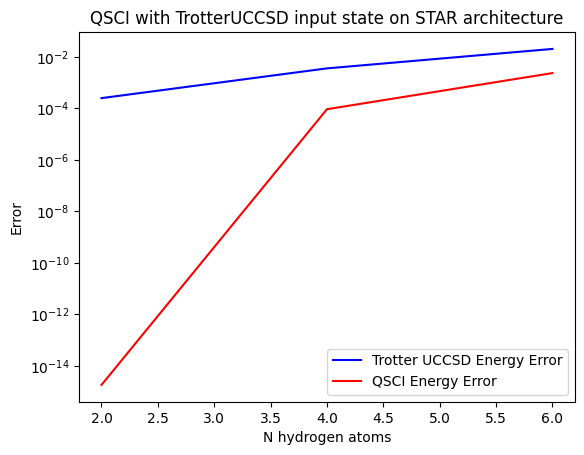

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import Axes

ax: Axes = plt.axes()

ax.semilogy(n_list, trotter_uccsd_energy_err, "b")
ax.semilogy(n_list, qsci_energy_err, "r")
ax.legend(
    [
        "Trotter UCCSD Energy Error",
        "QSCI Energy Error",
    ]
)
ax.set_title("QSCI with TrotterUCCSD input state on STAR architecture")
ax.set_xlabel("N hydrogen atoms")
ax.set_ylabel("Error")

As seen above the QSCI energy error is consistently lower than the one obtained by TrotterUCCSD. This is because QSCI can obtain nearly exact results as long as a substantial amount of reference states are used. Even in the presence of a modest amount of noise, as long as the noise does not alter the set of preferred reference states that are obtained from sampling, the resulting diagonalization is unaffected. This is what makes QSCI a powerful technique.

Now let's also look at the resulting fidelity, this time including device dependent results that depend on noise.

Text(0, 0.5, 'Fidelity')

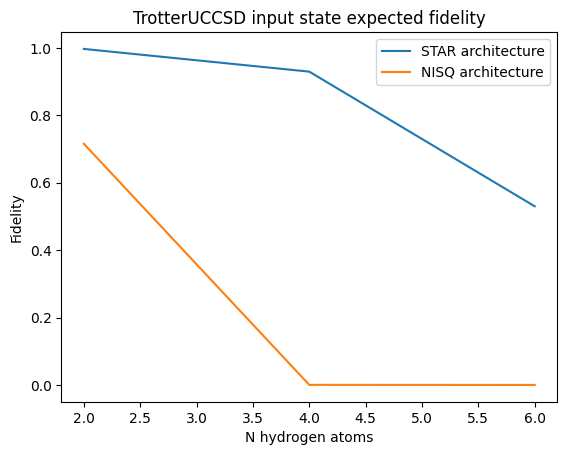

In [ ]:
ax: Axes = plt.axes()

ax.plot(n_list, circuit_fidelity_star)
ax.plot(n_list, circuit_fidelity_nisq)
ax.legend(
    [
        "STAR architecture",
        "NISQ architecture",
    ]
)
ax.set_title("TrotterUCCSD input state expected fidelity")
ax.set_xlabel("N hydrogen atoms")
ax.set_ylabel("Fidelity")

## Summary

This notebook introduced QSCI based on the TrotterUCCSD ansatz. The learning outcomes included

- Simple molecular Hamiltonians and CC theory using PySCF
- TrotterUCCSD ansatz
- Using QSCI
- Transpiling and optimizing circuits
- Estimating fidelities of deep circuits with different architectures
- The performance of QSCI based on Trotter UCCSD

### Now, why don't you try ...

Compared to the simple noise model we used here, QURI Parts has several options for [noisy simulations](https://quri-parts.qunasys.com/docs/tutorials/basics/noise_error/). As a suggestion for self-study, try to see how QSCI performs in a noisy environment using device inspired parameters.